# Prelim Skills Exam

**Performed by:**San Gabriel, Nil Jedidiah G.
**Class Code:** CPE 313-CPE32S8 
**Date Preformed:** 3/17/2024 
**Date Submitted:** 3/17/2024 
**Submitted to:** Engr. Roman Richard 

#### Objective(s):

Do the following using the CHEST x-rays dataset

[NIH Xrays](https://www.kaggle.com/datasets/nih-chest-xrays/data/data) to an external site.

1. Build and train a CNN model from a scratch.  Apply different regularization techniques and data preprocessing to reduce overfitting.

2.  Plot the training and validation loss and accuracy. The target accuracy is 85 and above.

3.  Use the assigned pre-trained model and fine-tuned it. 

4. Build and train a CNN model using the modified pretrained model.

5. Plot the training and validation loss and accuracy. The target accuracy is 95 and above.

6. Use the classification report, confusion matrix and ROC over AUC metric to evaluate also the performance of the scratch and using pre-trained mode

## Data Preprocessing

In [1]:
## Import necessary libraries
import numpy as np 
import pandas as pd 
import os
import cv2
from itertools import chain
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('xray_data/Data_Entry_2017.csv',
                          skipinitialspace=True)

## Find all images in a folder
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('xray_data', 'images*', '*', '*.png'))}

len(all_image_paths), df.shape[0] # Check found images and row shape

(112120, 112120)

In [3]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
df['img_path'] = df['Image Index'].map(all_image_paths.get)
df.drop(columns='Unnamed: 11', inplace=True)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],img_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,xray_data\images_001\images\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,xray_data\images_001\images\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,xray_data\images_001\images\00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,xray_data\images_001\images\00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,xray_data\images_001\images\00000003_000.png


Image paths are tracked and placed on a column, this will be useful later when generating image data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  img_path                     112120 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 10.3+ MB


In [6]:
df.isna().sum()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
img_path                       0
dtype: int64

In [7]:
df['Finding Labels'].value_counts()

Finding Labels
No Finding                                                         60361
Infiltration                                                        9547
Atelectasis                                                         4215
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia        1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax         1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax                  1
Edema|Infiltration|Pneumothorax                                        1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax         1
Name: count, Length: 836, dtype: int64

In [8]:
## Separates diseases from one another
labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x)>0]
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [9]:
## One hot encoding for the labels
for label in labels:
    df[label] = df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

In [10]:
df.drop(columns=df.columns[2:11], inplace=True)

Since the other columns won't do as much to affect the model, it is safe to remove these columns

In [11]:
df.head()

,Image Index,Finding Labels,img_path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,xray_data\images_001\images\00000001_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,xray_data\images_001\images\00000001_001.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,xray_data\images_001\images\00000001_002.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,xray_data\images_001\images\00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,xray_data\images_001\images\00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting Training set and Testing set

In [54]:
## Import Keras libraries

import tensorflow
import keras
from keras import regularizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score

In [13]:
## Setting the image data generator paramaeters
datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True,
                              rescale=1./255, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

Image must be augmented in order for the model to learn more about the model

In [14]:
##Splitting of sizes
split = int(df.shape[0]*.8) # take 80% of the data
split

89696

In [15]:
train_data = df.iloc[:split, 2:]
test_data = df.iloc[split:, 2:]

(test_data.shape[0]+train_data.shape[0]) == df.shape[0]

True

Since the train and test shapes returned an equal value with the shape of the orifinal dataframe this means that the splitting are 80:20

## Model Training

#### data functions

In [16]:
## plot the graph
def plot_loss_accuracy(history, name):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('binary_cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["binary_accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_binary_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('binary_accuracy')
    ax.grid(True)
    
    plt.suptitle(name)

In [17]:
def plot_roc_auc(predicted, validation, df_labels):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = predicted.shape[1]  # Number of classes

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(validation.labels[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Plot the ROC curve for each class
    plt.figure(figsize=(10, 10))

    for i in range(13):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve ({df_labels[i]}) (AUC = {roc_auc[i]:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc='lower right')
    plt.show()

#### Image data Generator

In [18]:
size = 128

train_gen = datagen.flow_from_dataframe(
    directory=None,
    target_size=(size, size),
    batch_size=32,
    class_mode='raw',
    dataframe=train_data,
    x_col='img_path',
    y_col=list(train_data.columns[1:])
)

test_gen = datagen.flow_from_dataframe(
    directory=None,
    target_size=(size, size),
    batch_size=256,
    class_mode='raw',
    dataframe=test_data,
    x_col='img_path',
    y_col=list(test_data.columns[1:])
)

X_test, y_test = next(datagen.flow_from_dataframe(directory=None,
                                                 target_size=(size, size),
                                                 batch_size=1024,
                                                 class_mode='raw',
                                                 dataframe=test_data,
                                                 x_col='img_path',
                                                 y_col=list(test_data.columns[1:])
                                                 )) # one big batch



Found 89696 validated image filenames.
Found 22424 validated image filenames.
Found 22424 validated image filenames.


#### Building a neural network

In [19]:
## Create the model
model_1 = Sequential()

model_1.add(Conv2D(16, (5, 5), strides=(1, 1), padding='same',
                 input_shape=(size, size, 3),
                 kernel_regularizer=regularizers.l2(0.001)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(16, (5, 5), strides=(1, 1), padding='same',
                   kernel_regularizer=regularizers.l2(0.001)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same',
                   kernel_regularizer=regularizers.l2(0.0001)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Flatten())

model_1.add(Dense(128))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(len(labels)))
model_1.add(Activation('sigmoid'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      1216      
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        6416      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 16)        0         
                                                        

A model with a total parameters of `2,116,127`

In [20]:
model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy', 'accuracy'])

history_1 = model_1.fit(train_gen,
                        steps_per_epoch=500,
                        epochs=10,
                        validation_data=test_gen,
                        callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=1)]
                                   )

Epoch 1/10
500/500 [==============================] - 528s 1s/step - loss: 0.2491 - binary_accuracy: 0.9208 - accuracy: 0.5139 - val_loss: 0.2825 - val_binary_accuracy: 0.9254 - val_accuracy: 0.5314
Epoch 2/10
500/500 [==============================] - 527s 1s/step - loss: 0.2255 - binary_accuracy: 0.9252 - accuracy: 0.5391 - val_loss: 0.2242 - val_binary_accuracy: 0.9266 - val_accuracy: 0.5314
Epoch 3/10
500/500 [==============================] - 524s 1s/step - loss: 0.2223 - binary_accuracy: 0.9253 - accuracy: 0.5328 - val_loss: 0.2247 - val_binary_accuracy: 0.9269 - val_accuracy: 0.5291
Epoch 4/10
500/500 [==============================] - 521s 1s/step - loss: 0.2155 - binary_accuracy: 0.9270 - accuracy: 0.5446 - val_loss: 0.2215 - val_binary_accuracy: 0.9267 - val_accuracy: 0.5300
Epoch 5/10
500/500 [==============================] - 519s 1s/step - loss: 0.2174 - binary_accuracy: 0.9262 - accuracy: 0.5347 - val_loss: 0.2083 - val_binary_accuracy: 0.9272 - val_accuracy: 0.5312


In [21]:
score_1 = model_1.evaluate(test_gen)
print("Validation Loss: ", score_1[0])
print("Validation Accuracy: ", score_1[1])

88/88 [==============================] - 296s 3s/step - loss: 0.2083 - binary_accuracy: 0.9271 - accuracy: 0.5302
Validation Loss:  0.20833086967468262
Validation Accuracy:  0.9271167516708374


#### Plotting the Loss and Accuracy

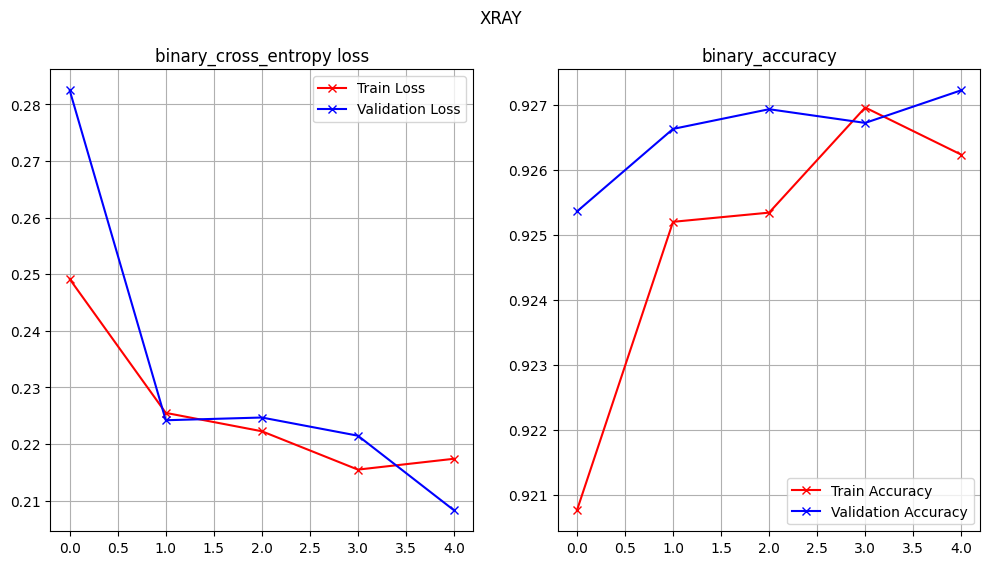

In [22]:
plot_loss_accuracy(history_1, 'XRAY')

The accuracy of the model have a small gap between with each other which has a good performance, this also means that the model is not overfitted because if the small gap between each other. Loss is also small, having small errors in the model, since the gap between the training loss and validation loss is also small, this means that the model has a good generalization of values.

In [23]:
pred_1 = model_1.predict(test_gen, batch_size=32, verbose=1)

88/88 [==============================] - 290s 3s/step


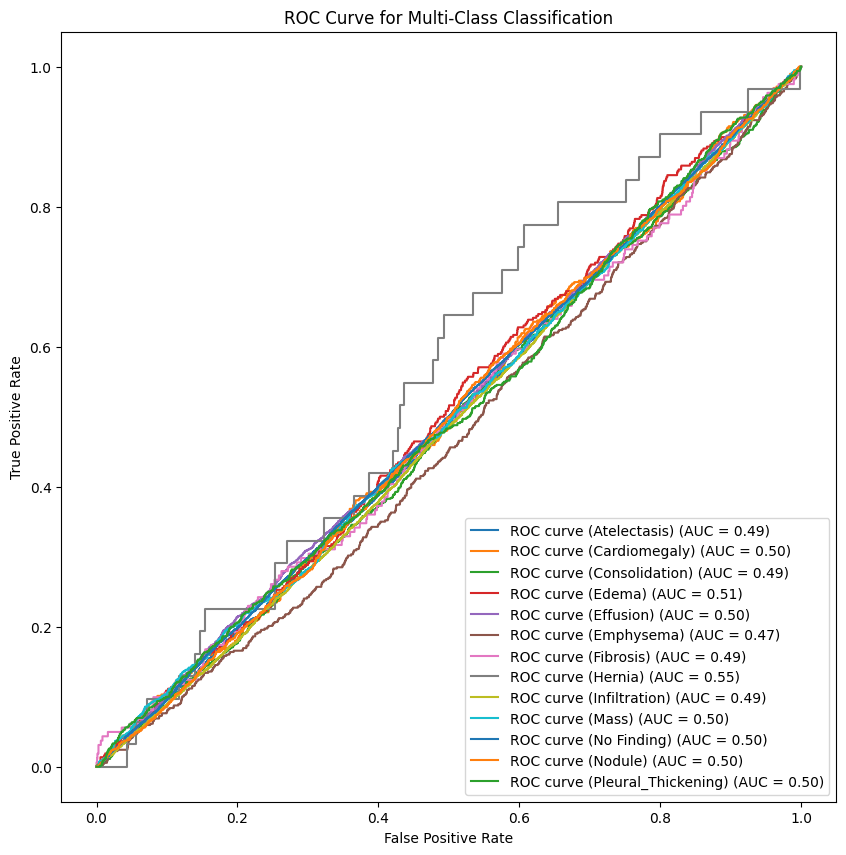

In [24]:
plot_roc_auc(pred_1, test_gen, labels)

Roc curve did not perform well, having a low score

#### Using a pre-trained model

In [25]:
from keras.applications import xception

preTrained_model = xception.Xception(input_shape=(128, 128, 3),
                                   include_top=False,
                                   weights=None)

In [26]:
len(preTrained_model.layers) 

132

In [27]:
for l in preTrained_model.layers[:128]:
    l.trainable=False

In [28]:
## Create the model
model_2 = Sequential()
model_2.add(preTrained_model)
model_2.add(GlobalAveragePooling2D())

model_2.add(Dense(512))
model_2.add(Dropout(0.5))
model_2.add(Dense(len(labels)))
model_2.add(Activation('sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 15)                7695      
                                                                 
 activation_5 (Activation)   (None, 15)                0         
                                                      

total paramaters of `21,918,263` but `17,697,832` was freezed to reduce the complexity of the model

In [29]:
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy', 'AUC'])

history_2 = model_2.fit_generator(generator=train_gen,
                        steps_per_epoch=400,
                        epochs=100,
                        callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=1)],
                        validation_data=test_gen)

C:\Users\Nil\AppData\Local\Temp\ipykernel_13672\377476235.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_2 = model_2.fit_generator(generator=train_gen,


Epoch 1/100
400/400 [==============================] - 485s 1s/step - loss: 0.2305 - binary_accuracy: 0.9206 - auc: 0.8156 - val_loss: 0.2158 - val_binary_accuracy: 0.9247 - val_auc: 0.8482
Epoch 2/100
400/400 [==============================] - 472s 1s/step - loss: 0.2181 - binary_accuracy: 0.9230 - auc: 0.8326 - val_loss: 0.2180 - val_binary_accuracy: 0.9224 - val_auc: 0.8502
Epoch 3/100
400/400 [==============================] - 480s 1s/step - loss: 0.2147 - binary_accuracy: 0.9249 - auc: 0.8389 - val_loss: 0.2166 - val_binary_accuracy: 0.9213 - val_auc: 0.8528
Epoch 4/100
400/400 [==============================] - 482s 1s/step - loss: 0.2144 - binary_accuracy: 0.9248 - auc: 0.8393 - val_loss: 0.2076 - val_binary_accuracy: 0.9260 - val_auc: 0.8588
Epoch 5/100
400/400 [==============================] - 491s 1s/step - loss: 0.2124 - binary_accuracy: 0.9256 - auc: 0.8431 - val_loss: 0.2166 - val_binary_accuracy: 0.9243 - val_auc: 0.8593
Epoch 6/100
400/400 [=============================

In [30]:
score_2 = model_2.evaluate(test_gen)
print("Validation Loss: ", score_2[0])
print("Validation Accuracy: ", score_2[1])

88/88 [==============================] - 303s 3s/step - loss: 0.2080 - binary_accuracy: 0.9258 - auc: 0.8594
Validation Loss:  0.20804420113563538
Validation Accuracy:  0.9257999658584595


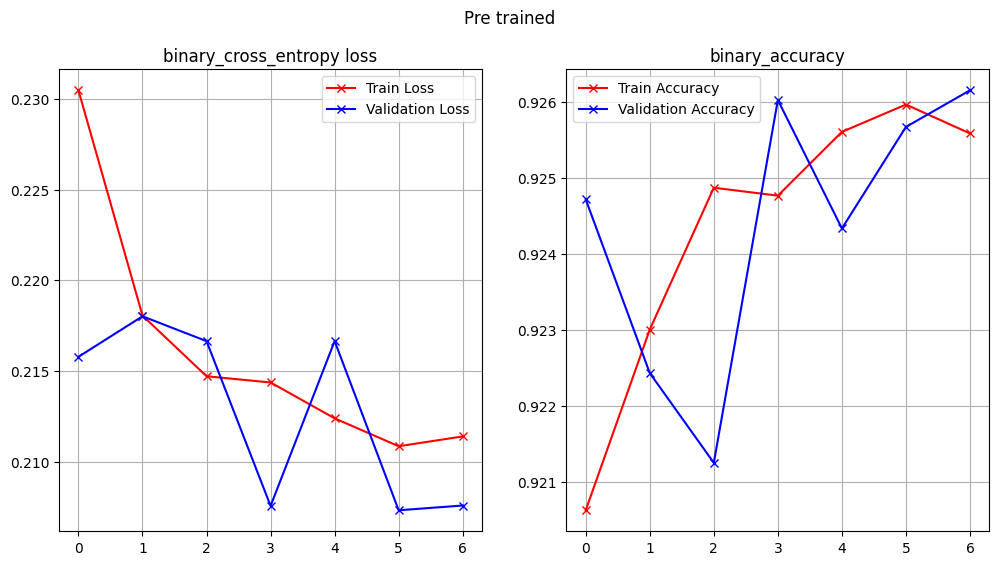

In [31]:
plot_loss_accuracy(history_2, 'Pre trained')

88/88 [==============================] - 314s 4s/step


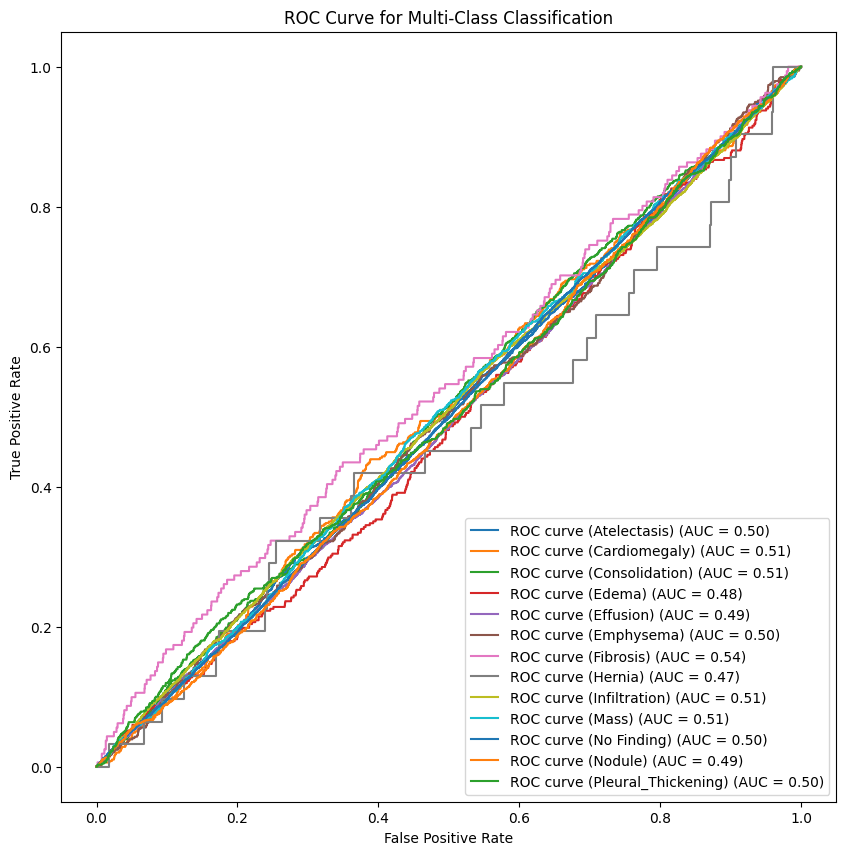

In [32]:
pred_2 = model_2.predict(test_gen, batch_size=32, verbose=1)
plot_roc_auc(pred_2, test_gen, labels)

#### Conclusion and Lesson learned

***During the activity we were tasked to create a Convulutional Neural Network using the NIH X rays which contained 110k pictures of patients with labeled diseases. The first thing to do was to clean the data, see if there are data types that needed convertion and any null values that may affect the model when training. This includes separation of labels by their unique values, if it is not done the model will result in having a really bad performance since the classes are more than 800; therefore reduction of classes is needed, after getting all unique values, it is then turned into columns or one hot encoded. After data cleaning the dataset can now be trained via model.<br><br>The model created from scratch contained `2,116,127` parameters with 3 convulutional layers, an input size of `(128,128,3)`, a dropout of `0.5`, and an aoutput layer having `15 neurons`. The training lasted for about 43 mins, and stopped at epoch 5 since the patience added was only 1. It resulted into a model with an accuracy of 92%.<br><br> The next model created was a pre-trained model from keras, `Xception` was chosen because of the accuracy on the documentation but it did not produced a much higher accuracy than the fist model, it yielded an accuracy of 92%. Both roc curve did not perform well, all were less than 50%.<br><br> When doing this activity I had a hard time since CNN is really difficult to implement properly since this was a multiclass labled, having  more than 2 classes. This activty also took a lot of time to finish since deep learning a lot of computations was used even if cuda was involed, this also depended on how the structure of the network was made; the larger the network, the slower the training will become. There is also an `Out Of Memory` error which reuslts when the network is too complex and large, reduction of steps solved this error but the training time is stil slow. Overall it was really challenging and time consuming since there is no exact/default design of a network that will be used in deep learning, experimentation is needed to get the best peformance of the model.***